# Example taken from http://dmnfarrell.github.io/bioinformatics/abm-mesa-python

In [1]:
import time
import enum
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [2]:
class InfectionModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, width=10, height=10, ptrans=0.5,
                 death_rate=0.02, recovery_days=21,
                 recovery_sd=7):

        self.num_agents = N
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.98,0.02])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,40)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""

        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED

    def contact(self):
        """Find close contacts and infect"""

        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()

    def step(self):
        self.status()
        self.move()
        self.contact()

In [4]:
pop = 295
steps = 100
model = InfectionModel(pop, 20, 20, ptrans=0.5)
for i in range(steps):
    model.step()
agent_state = model.datacollector.get_agent_vars_dataframe()

In [5]:
def get_column_data(model):
    """pivot the model dataframe to get states count at each step"""
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X

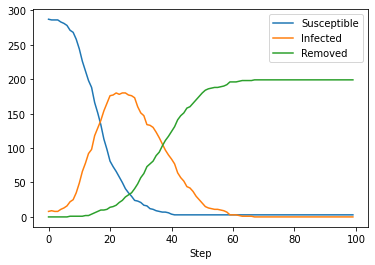

In [6]:
get_column_data(model).plot.line()

## Below is stuff for visualization which uses another library

In [7]:
def plot_states_bokeh(model,title=''):
    """Plot cases per country"""

    X = get_column_data(model)
    X = X.reset_index()
    source = ColumnDataSource(X)
    i=0
    colors = Category10[3]
    items=[]
    p = figure(plot_width=600,plot_height=400,tools=[],title=title,x_range=(0,100))        
    for c in X.columns[1:]:
        line = Line(x='Step',y=c, line_color=colors[i],line_width=3,line_alpha=.8,name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c,[glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right',   
                items=items))
    p.background_fill_color = "#e1e1ea"
    p.background_fill_alpha = 0.5
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p

In [8]:
def grid_values(model):
    """Get grid cell states"""

    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=pd.DataFrame(agent_counts)
    for cell in model.grid.coord_iter():
        agents, x, y = cell
        c=None
        for a in agents:
            c = a.state
        df.iloc[x,y] = c
    return df

def plot_cells_bokeh(model):

    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model)
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]    
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    colors = Category10[3]
    mapper = LinearColorMapper(palette=colors, low=df.value.min(), high=df.value.max())
    p = figure(plot_width=500,plot_height=500, tools=[hover], x_range=(-1,w), y_range=(-1,w))
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "black"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

In [9]:
import panel as pn
pn.extension()
plot_pane = pn.pane.Bokeh()
grid_pane = pn.pane.Bokeh()
pn.Row(plot_pane,grid_pane,sizing_mode='stretch_width')

steps=100
pop=400
model = InfectionModel(pop, 20, 20, ptrans=0.25, death_rate=0.01)
for i in range(steps):
    model.step()    
    p1=plot_states_bokeh(model,title='step=%s' %i)
    plot_pane.object = p1
    p2=plot_cells_bokeh(model)
    grid_pane.object = p2
    time.sleep(0.2)

ModuleNotFoundError: No module named 'panel'

In [10]:
grid_values(model)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,2.0,1.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,0.0,NaN,2.0,2.0,2.0,NaN,NaN,2.0,2.0,NaN,2.0,1.0,2.0,2.0,2.0,NaN,2.0,NaN,1.0,NaN
2,1.0,NaN,NaN,2.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1.0,1.0,NaN
3,NaN,NaN,2.0,NaN,NaN,1.0,2.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,2.0,NaN,2.0,NaN,2.0,2.0
4,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,2.0,1.0,NaN,1.0,2.0,NaN,NaN
5,NaN,2.0,2.0,NaN,2.0,1.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,2.0,NaN,2.0,2.0,1.0
6,1.0,NaN,2.0,1.0,NaN,2.0,2.0,1.0,2.0,NaN,1.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.0,2.0
7,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,2.0,NaN,1.0,NaN,NaN,2.0,NaN,2.0,NaN,2.0,NaN
8,2.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,2.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0
9,NaN,2.0,NaN,2.0,1.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,2.0,2.0,2.0,1.0,NaN,2.0,NaN,NaN
